# Effect of financial crisis on banking sector


In [ ]:
import sys
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install yfinance
!{sys.executable} -m pip install requests 
!{sys.executable} -m pip install datetime
!{sys.executable} -m pip install scipy
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install bootstrap-stat
!{sys.executable} -m pip install copulas
!{sys.executable} -m pip install arch
!{sys.executable} install -U yellowbrick

In [5]:
import yfinance as yf
import pandas as pd
import numpy as np
import datetime
import requests
import scipy
from IPython.display import display, HTML, display_html
from bootstrap_stat import bootstrap_stat as bp

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, minmax_scale, StandardScaler
from sklearn.decomposition import PCA
from sklearn import linear_model, tree, svm
from sklearn.metrics import r2_score, accuracy_score, mean_absolute_error, mean_squared_error
from sklearn.covariance import GraphicalLassoCV

import itertools

from scipy import stats
from scipy.stats import shapiro, probplot

import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_arch
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller,  grangercausalitytests
from statsmodels.tsa.api import VAR
from statsmodels.sandbox.tools.tools_pca import pcasvd

import random

import pandas.util.testing as tm

from pandas.plotting import scatter_matrix

from arch import arch_model
from math import sqrt
from collections import OrderedDict
from itertools import combinations
import pylab


import networkx as nx
import copulas
import copulas.bivariate
import copulas.multivariate
import copulas.visualization

import warnings

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation
import time

warnings.filterwarnings('ignore')

# 1. Data Importing
## 1.1 Choose a financial crisis of the last 100 years.  Be sure that you can find data for the crisis you select.  (Otherwise, select a different crisis)

We will be choosing the 2008 finanical crisis, also known as the great recession (will be expanding from this link: https://en.wikipedia.org/wiki/Causes_of_the_Great_Recession). 

## 1.2 Identify the key market factors


1. Housing market crisis- excessive subprime mortgages
2. Inaccurate credit ratings
3. Excessive risk taking behavior by finanicial institutions.

# 2. Data Processing
## 2.1 Find at least 5 securities, macroeconomic indicators, or other factors that were signficantly affected by the crisis.

Because the financial crisis began due to the mismanagement of the risk factors pertaining to the packaging of subprime mortgages; we shall take five banking corporation stocks for our assessment purposes.


## 2.2 Be sure to collect data that starts 6 months prior to the crisis, and goes 6 months after the crisis.

Since the peak of the great recession is termed to be from and around September 2008, we shall take the months of september 2008, october 2008, november 2008, december 2008, januart 2009, and february 2009; as the post six months since the crisis first began.

The months of march 2008, april 2008, may 2008, june 2008, july 2008, and august 2008; as the pre six months since the crisis first began.


In [7]:
# Dataframe having list of stocks with their ticker symbols
stocklist = pd.DataFrame([['Bank of America', 'BAC'], ['CitiGroup','C'], ['Goldman Sachs', 'GS'], ['JPMorgan Chase', 'JPM'],
                                  ['Morgan Stanley','MS'], ['Wells Fargo','WFC']], columns= ['stock','symbol'])
stocklist


,stock,symbol
0,Bank of America,BAC
1,CitiGroup,C
2,Goldman Sachs,GS
3,JPMorgan Chase,JPM
4,Morgan Stanley,MS
5,Wells Fargo,WFC


In [11]:
start_date = datetime.datetime(2008, 3, 3 )
end_date = datetime.datetime(2009, 2, 28)

# using the banks as the five securities 

symbols = ['BAC', 'C', 'GS', 'JPM', 'MS', 'WFC']

data = pd.DataFrame()

for sym in symbols: 
  try: 
    fund = []
    fund = yf.download(sym, start = start_date, end = end_date, progress = True)
    if (len(fund) == 0):
        None
    else:
        fund['Name'] = sym
        data = data.append(fund, sort = False)
  except Exception:
    None


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


### Data Frequency Alignment

The frequences are all daily as can be seen

In [12]:
data

,Open,High,Low,Close,Adj Close,Volume,Name
Date,,,,,,,
2008-03-03,39.740002,39.959999,38.570000,39.180000,31.394745,37261500,BAC
2008-03-04,38.759998,39.090000,37.779999,38.779999,31.074224,46582400,BAC
2008-03-05,38.650002,38.730000,37.209999,37.549999,30.593515,51850800,BAC
2008-03-06,36.950001,37.230000,36.279999,36.520000,29.754347,51961200,BAC
2008-03-07,36.040001,37.570000,35.900002,36.740002,29.933578,43862700,BAC
...,...,...,...,...,...,...,...
2009-02-23,11.760000,12.950000,10.560000,11.030000,8.075091,225178200,WFC
2009-02-24,11.390000,13.110000,11.150000,13.050000,9.553942,187177900,WFC
2009-02-25,12.960000,14.080000,11.770000,13.440000,9.839461,209935600,WFC


### Compute Daily Returns

In [13]:
df = data[['Adj Close', 'Name']].pivot(columns='Name') 
df.columns = df.columns.droplevel(0)
returns = df.pct_change().dropna()

logreturns = np.log1p(df.pct_change()).dropna() 
#returns = np.log2(df).diff().dropna()

display(returns)

Name,BAC,C,GS,JPM,MS,WFC
Date,,,,,,
2008-03-04,-0.010209,-0.042876,-0.008965,-0.015822,-0.005531,-0.001385
2008-03-05,-0.015470,0.002263,0.008373,-0.011482,0.002902,0.005203
2008-03-06,-0.027430,-0.044244,-0.038309,-0.035364,-0.043405,-0.039682
2008-03-07,0.006024,-0.012281,0.008950,0.005084,0.004789,0.010061
2008-03-10,-0.038922,-0.058346,-0.028050,-0.028754,-0.039137,-0.007826
...,...,...,...,...,...,...
2009-02-23,0.031662,0.097436,-0.053434,-0.019598,-0.031395,0.010999
2009-02-24,0.209719,0.214953,0.161234,0.077396,0.172689,0.183137
2009-02-25,0.090909,-0.030769,-0.032910,0.033778,-0.014046,0.029885


Name,BAC,C,GS,JPM,MS,WFC
Date,,,,,,
2008-03-04,-0.010209,-0.042876,-0.008965,-0.015822,-0.005531,-0.001385
2008-03-05,-0.015470,0.002263,0.008373,-0.011482,0.002902,0.005203
2008-03-06,-0.027430,-0.044244,-0.038309,-0.035364,-0.043405,-0.039682
2008-03-07,0.006024,-0.012281,0.008950,0.005084,0.004789,0.010061
2008-03-10,-0.038922,-0.058346,-0.028050,-0.028754,-0.039137,-0.007826


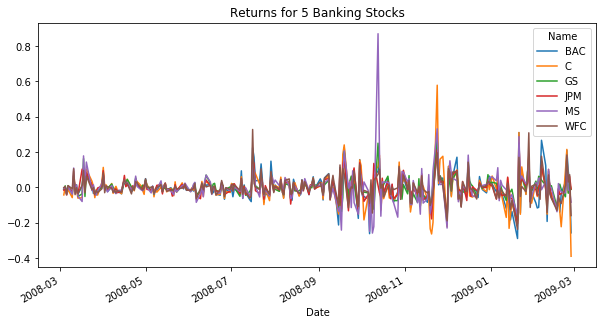

In [19]:
returns.plot(figsize=(10, 5), title='Returns for 5 Banking Stocks')
returns.head()

# 3. Visualizing data

## 3.1 Show 3 different multivariate displays & 3.2 Show a scatterplot matrix of each pairwise returns

The datasets being used are 2-dimensional. In this section, we focus on visualizing the statistical distributions of the timeseries returns data through the following visualizations:
*   Correlation Heatmap
*   Covariance Heatmap
*   Log Returns Box Plot
*   Joint Plots
*   Scatter Plot Matrices 



### Heatmap

We plot a heatmap of the correlations and covariances between the different equities to quickly identify strong vs weak relationships.

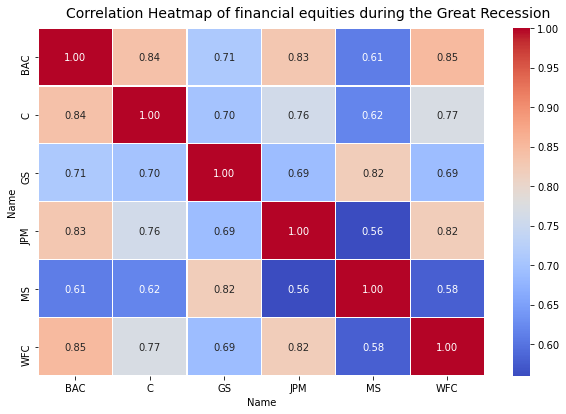

In [ ]:
f, ax = plt.subplots(figsize=(10, 6))
corr = returns.corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
                 linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('Correlation Heatmap of financial equities during the Great Recession', fontsize=14)

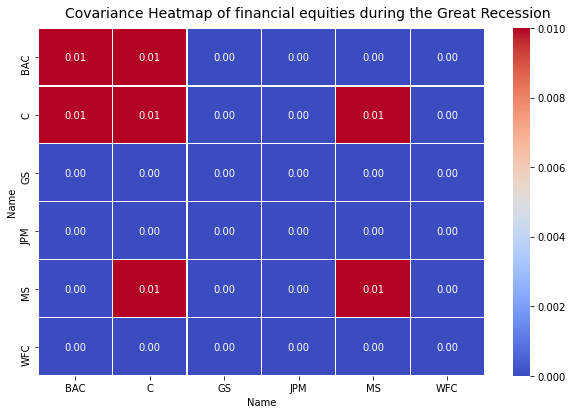

In [ ]:
f, ax = plt.subplots(figsize=(10, 6))
cov = returns.cov()
hm = sns.heatmap(round(cov,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
                 linewidths=.05)
f.subplots_adjust(top=0.93)
t= f.suptitle('Covariance Heatmap of financial equities during the Great Recession', fontsize=14)

### Log Returns Box Plot


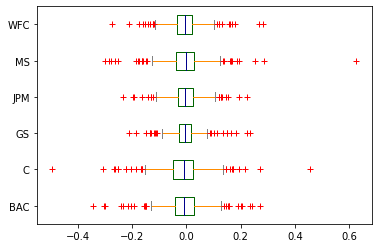

In [ ]:
color = {"boxes": "DarkGreen", "whiskers": "DarkOrange", "medians": "DarkBlue", "caps": "Gray", }
logreturns.plot.box(color=color, sym="r+",vert=False)

### Scatter Plot Matrices

Pair-wise scatter plots will help identify multivariate distributions that we can use in a later section of this assignment while fitting non-gaussian copula.

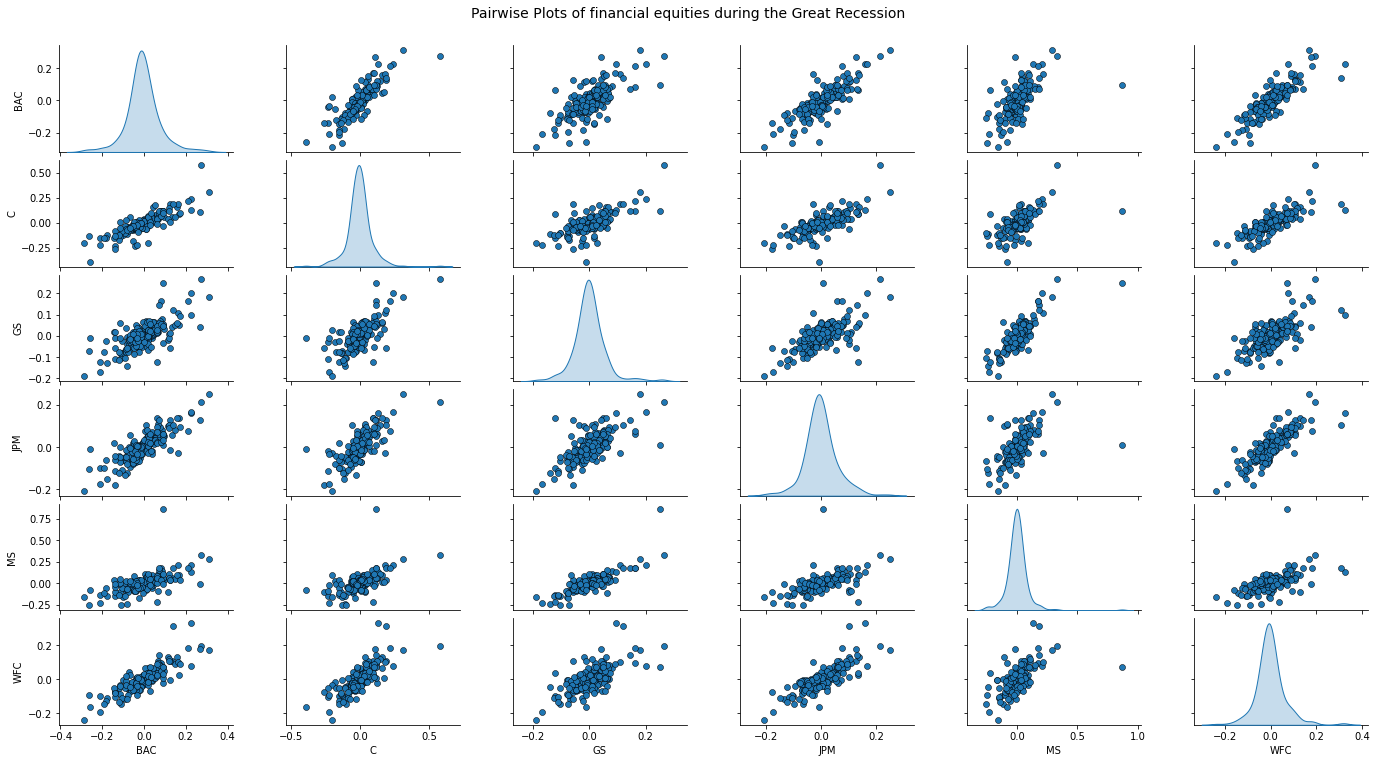

In [ ]:
pp = sns.pairplot(returns, size=1.8, aspect=1.8,
                  plot_kws=dict(edgecolor="k", linewidth=0.5),
                  diag_kind="kde", diag_kws=dict(shade=True))

fig = pp.fig 
fig.subplots_adjust(top=0.93, wspace=0.3)
t = fig.suptitle('Pairwise Plots of financial equities during the Great Recession', fontsize=14)

For each combination of the pairs we now carry out a regression joint plot, which provides an insight into the multivariate distributions that data might belong.

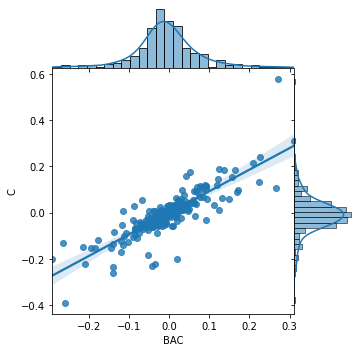

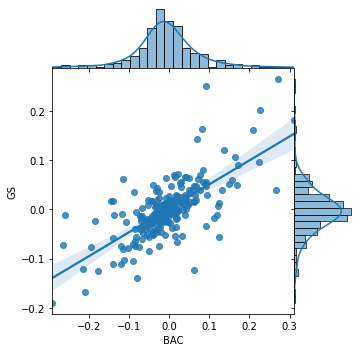

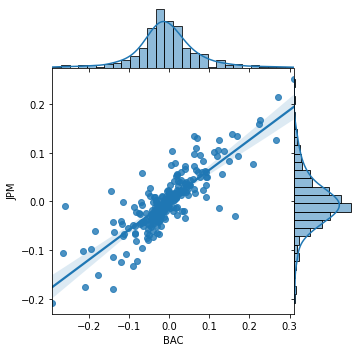

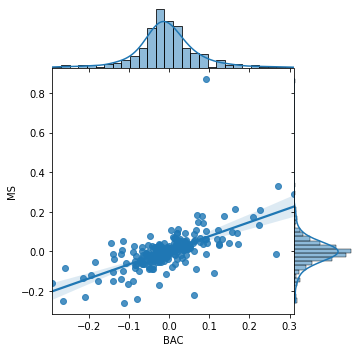

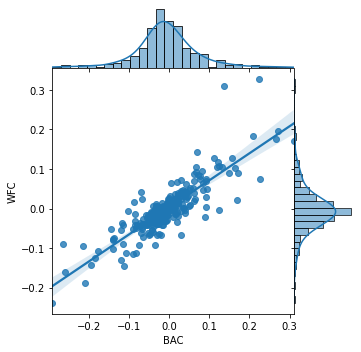

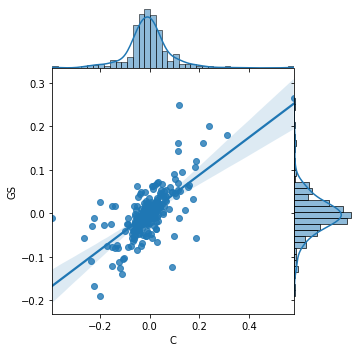

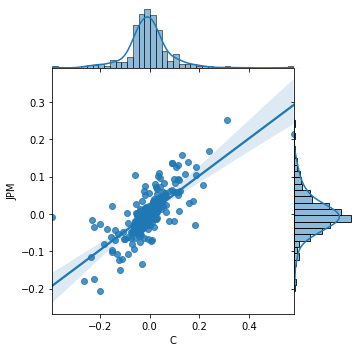

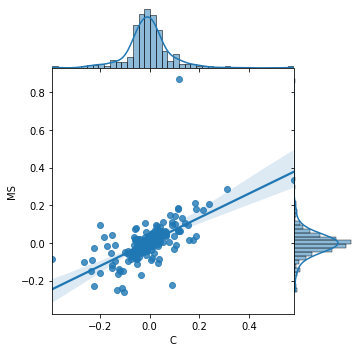

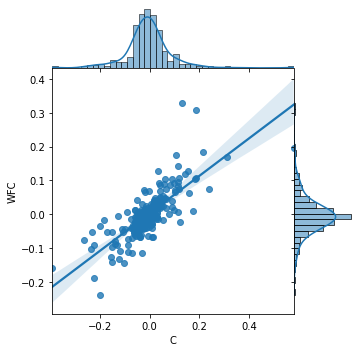

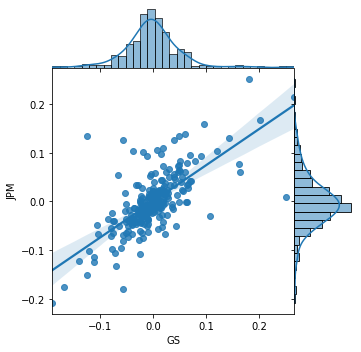

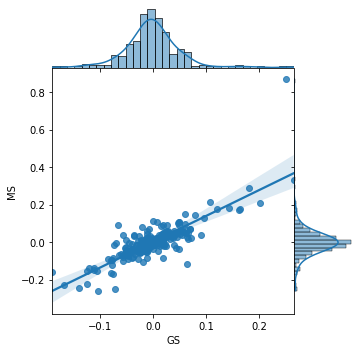

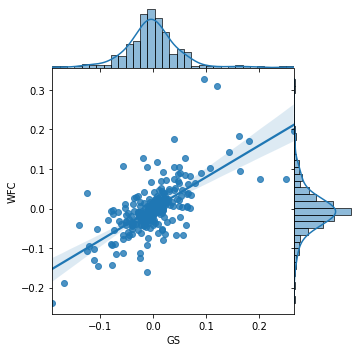

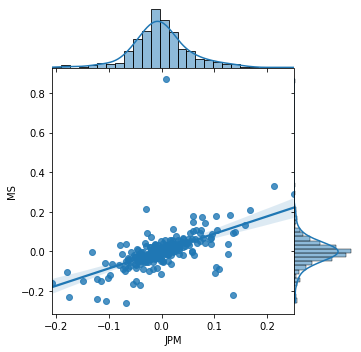

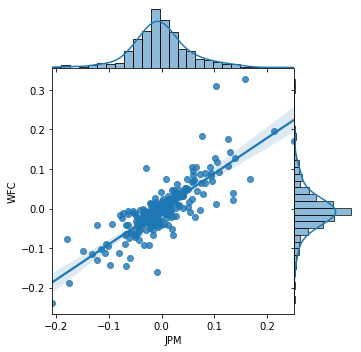

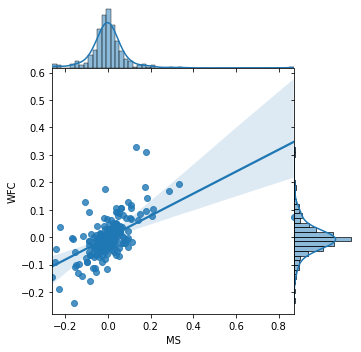

In [ ]:
for ticker1, ticker2 in combinations(returns.columns, 2):  # 2 for pairs, 3 for triplets....
    # Joint Plot
    jp = sns.jointplot(x=ticker1, y=ticker2, data=returns,
                    kind='reg', space=0, size=5, ratio=4)

## 3.3 Show a cluster analysis of the returns to see how the groups form.

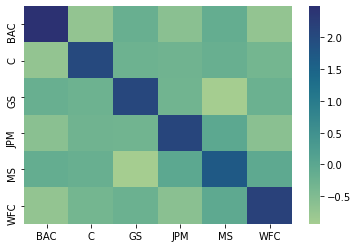

In [ ]:
rets_ = returns.copy()
edge_model = GraphicalLassoCV()
rets_ /= rets_.std(axis=0)
edge_model.fit(rets_)
partial_correlations = edge_model.precision_.copy()
sns.heatmap(partial_correlations, xticklabels=rets_.columns, yticklabels=rets_.columns, cmap="crest");

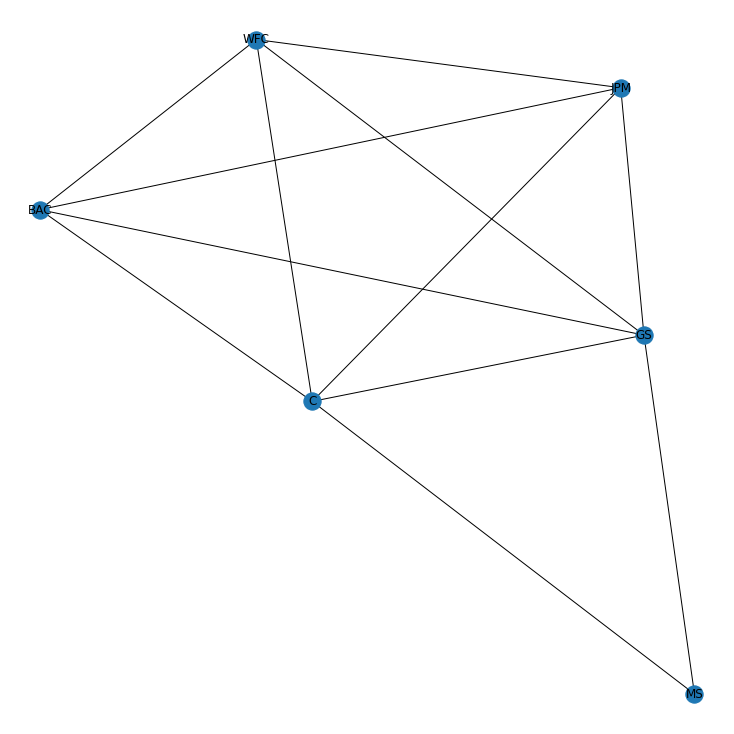

In [ ]:
partial_corr_df = pd.DataFrame(partial_correlations, columns=rets_.columns, index=rets_.columns)
links = partial_corr_df.stack().reset_index(level=1).rename(columns={'Name':'Name2'}).reset_index()
links.columns = ['1', '2','val']
links=links.loc[ (abs(links['val']) > 0.17) &  (links['1'] != links['2']) ]
#build the graph using networkx lib
G=nx.from_pandas_edgelist(links,'1','2', create_using=nx.Graph())
pos = nx.spring_layout(G, k=0.2*1/np.sqrt(len(G.nodes())), iterations=200)
plt.figure(3, figsize=(10, 10))
nx.draw(G, pos=pos)
nx.draw_networkx_labels(G, pos=pos)
plt.show()

## 3.4 Run a principal components, and show the biplots for the first 3 pairs of components.

In [ ]:
def biplot(plt, pca, colors=None,
           xpc=1, ypc=2, scale=1):
    xpc, ypc = (xpc - 1, ypc - 1)
    xreduced, factors, evals, evecs = pca
    singvals = np.sqrt(evals)

    # data
    xs = factors[:, xpc] * singvals[xpc]**(1. - scale)
    ys = factors[:, ypc] * singvals[ypc]**(1. - scale)

    colors = 'k' if colors is None else colors
    plt.scatter(xs, ys, c=colors, marker='.')

    # variables
    tvars = np.dot(np.eye(factors.shape[0], factors.shape[1]),
                   evecs) * singvals**scale

    for i, col in enumerate(xreduced.columns.values):
        x, y = tvars[i][xpc], tvars[i][ypc]
        plt.arrow(0, 0, x, y, color='r',
                  width=0.0002, head_width=0.005)
        plt.text(x* 1.4, y * 1.4, col, color='r', ha='center', va='center')

    plt.xlabel('PC{}'.format(xpc + 1))
    plt.ylabel('PC{}'.format(ypc + 1))

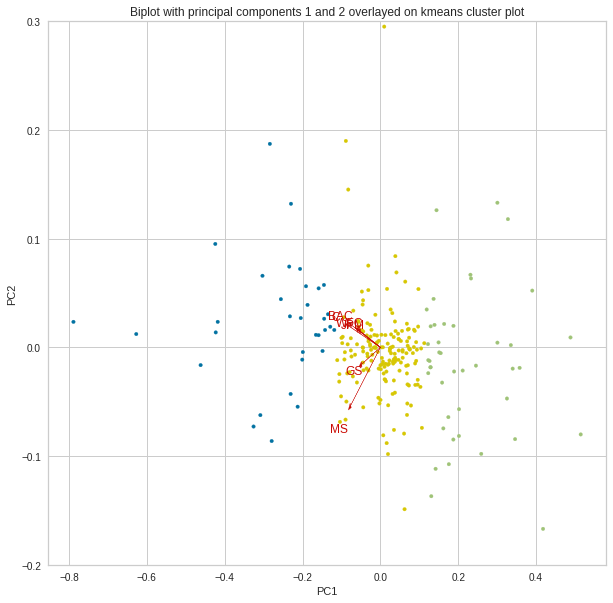

In [ ]:
pca = pcasvd(returns, keepdim=0, demean=False)

values = returns.values
centroids, _ = kmeans(values, 3)
idx, _ = vq(values, centroids)

colors = ['gby'[i] for i in idx]

plt.figure(figsize=(10,10))
biplot(plt, pca, colors=colors,
        xpc=1, ypc=2)
plt.ylim((-0.2,0.3))
plt.title("Biplot with principal components 1 and 2 overlayed on kmeans cluster plot")
plt.show()

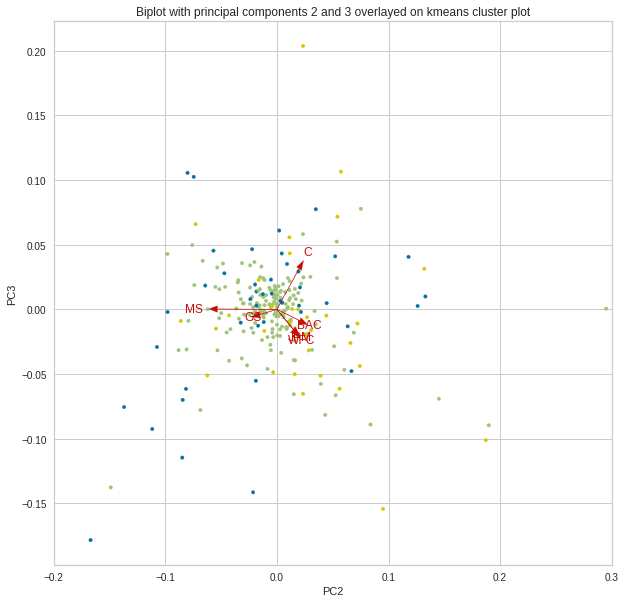

In [ ]:
plt.figure(figsize=(10,10))
biplot(plt, pca, colors=colors,
        xpc=2, ypc=3)
plt.xlim((-0.2,0.3))
plt.title("Biplot with principal components 2 and 3 overlayed on kmeans cluster plot")
plt.show()

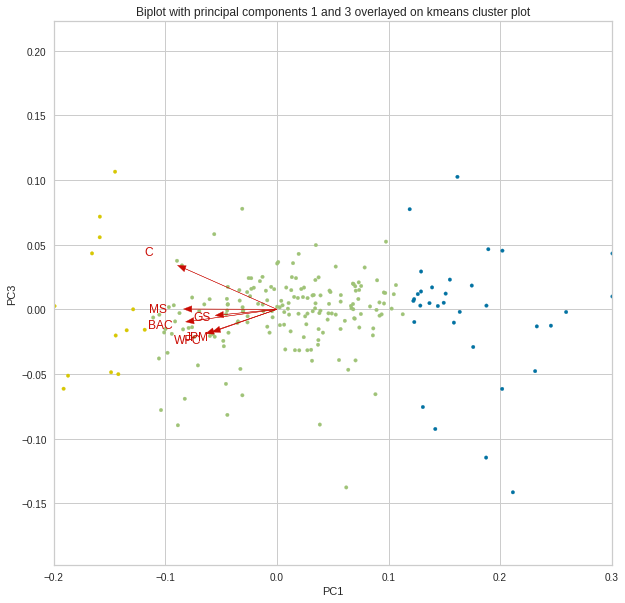

In [ ]:
plt.figure(figsize=(10,10))
biplot(plt, pca, colors=colors,
        xpc=1, ypc=3)
plt.xlim((-0.2,0.3))
plt.title("Biplot with principal components 1 and 3 overlayed on kmeans cluster plot")
plt.show()

# 4. Data Summaries.   Extreme Values


## 4.1 Compute means, standard deviations, skewness, and kurtosis for each distribution.

In [ ]:
summary = {}
summary['Mean'] = returns.mean()
summary['Standard Deviation'] = returns.std()
summary['Skewness'] = returns.skew()
summary['Kurtosis'] = returns.kurtosis()

In [ ]:
pd.DataFrame(summary).T

Name,BAC,C,GS,JPM,MS,WFC
Mean,-0.005566,-0.006684,-0.000822,-0.000312,0.000995,-0.001233
Standard Deviation,0.080617,0.090043,0.055604,0.059513,0.093509,0.064899
Skewness,0.300380,0.843979,0.916358,0.405595,3.269597,0.955720
Kurtosis,2.929437,8.729071,4.950707,2.538379,30.445232,5.302234


# 5. Copulas
In this section we fit two series selected earlier to fit to copulas. We carry out a comparison between a Gaussian copula and an Archimedean copula, namely the Gumbel distribution.

In [ ]:
# indices of tickers with highest excess kurtosis, 
# sorted from highest to lowest
max_kurt_idxs = np.argsort(np.abs(returns.kurtosis()))[::-1]
list(np.asarray(returns.columns)[max_kurt_idxs][:2])

['MS', 'C']

In [ ]:
rets_for_copula_modeling = returns[['MS', 'C']].dropna()

### 5.1 Gaussian Copula

Here is the data visualized pre-transformation side-by-side. 



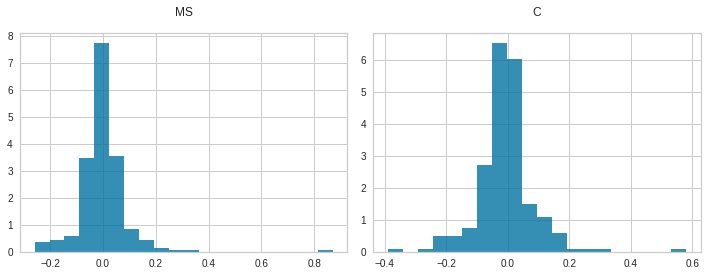

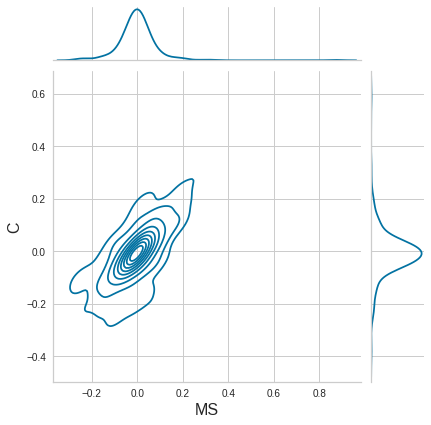

In [ ]:
copulas.visualization.side_by_side(
    copulas.visualization.hist_1d,
    {'MS': rets_for_copula_modeling['MS'], 'C': rets_for_copula_modeling['C']}
)
h = sns.jointplot(
    x=rets_for_copula_modeling['MS'], 
    y=rets_for_copula_modeling['C'], 
    kind='kde', 
    stat_func=None
)
h.set_axis_labels('MS', 'C', fontsize=16);

In [ ]:
print(
    "kendall's tau pre transformation:", 
    stats.kendalltau(x=rets_for_copula_modeling['MS'], y=rets_for_copula_modeling['C'])
)

kendall's tau pre transformation: KendalltauResult(correlation=0.5551485943775101, pvalue=4.579639870178227e-39)


A kendall's tau of 0.63 shows a strong positive correlation and that the pair is concordant. Since the p-value is less than 0.01, we can reject the null hypothesis.

In [ ]:
gauss_multivariate_copula = copulas.multivariate.GaussianMultivariate()
gauss_multivariate_copula.fit(rets_for_copula_modeling)

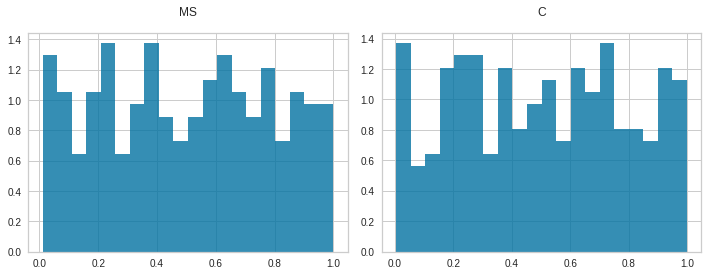

In [ ]:
ms_cdf = gauss_multivariate_copula.univariates[0].cdf(rets_for_copula_modeling['MS'])
c_cdf = gauss_multivariate_copula.univariates[1].cdf(rets_for_copula_modeling['C'])
copulas.visualization.side_by_side(
    copulas.visualization.hist_1d,
    {'MS': ms_cdf, 'C': c_cdf}
)

Upon fitting the data, the distribution looks as above. We have managed to make the distribution more uniform and we can sample synthetic data from it. 

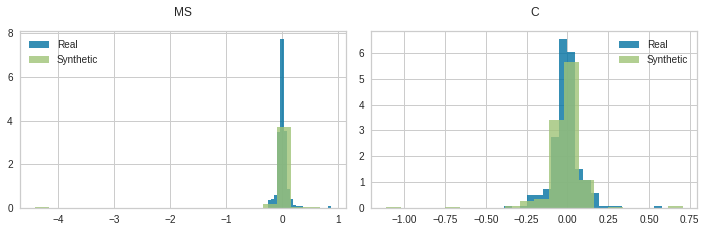

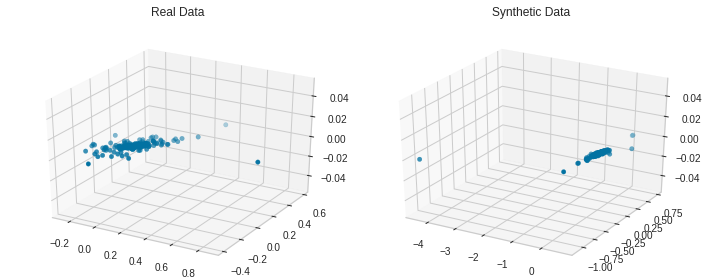

In [ ]:
sampled = gauss_multivariate_copula.sample(len(rets_for_copula_modeling))
copulas.visualization.compare_1d(rets_for_copula_modeling, sampled)
copulas.visualization.compare_3d(rets_for_copula_modeling, sampled)

In the diagram above, we show that the produced synthetic data is very similar to the real data fit to a copula based on statistical properties.
We now use the statistical properties (the mean and the correlation) of the returns data for an alternate visualization the data.

Generating synthetic data from fitted distribution model is essential when coming up with a mean reversion trading strategy such as pairs trading.

In [ ]:
correlation_gauss_copula = np.array(gauss_multivariate_copula.covariance)

In [ ]:
print(
    "The kendal's tau correlation for the gaussian copula is", 
    (2/np.pi)*np.arcsin(correlation_gauss_copula[0,1])
)

The kendal's tau correlation for the gaussian copula is 0.5053642569009945


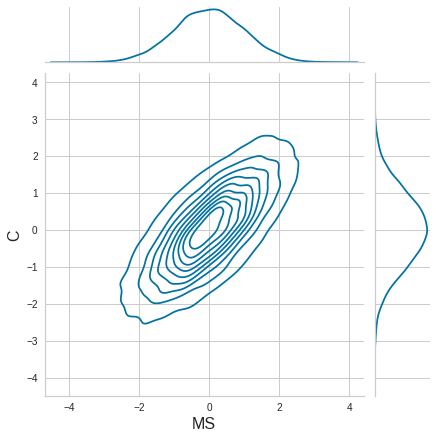

In [ ]:
mvnorm = stats.multivariate_normal(mean=[0,0], cov=correlation_gauss_copula)
viz_data = mvnorm.rvs(10_000)
h = sns.jointplot(x=viz_data[:, 0], y=viz_data[:, 1], kind='kde', stat_func=None);
h.set_axis_labels('MS', 'C', fontsize=16);

### 5.2 Non-Gaussian Copulas
The elliptical properties of the data indicate that this would be a good fit for the Gumbel copula which is a non-gaussian, archimedean copula

In [ ]:
rets_for_copula_modeling

Name,MS,C
Date,,
2008-03-04,-0.005531,-0.042876
2008-03-05,0.002902,0.002263
2008-03-06,-0.043405,-0.044244
2008-03-07,0.004789,-0.012281
2008-03-10,-0.039137,-0.058346
...,...,...
2009-02-23,-0.031395,0.097436
2009-02-24,0.172689,0.214953
2009-02-25,-0.014046,-0.030769


In [ ]:
rets_for_copula_modeling_scaled = \
    minmax_scale(rets_for_copula_modeling)

In [ ]:
non_gaussian_multivariate_copula = copulas.bivariate.gumbel.Gumbel()
non_gaussian_multivariate_copula.fit(rets_for_copula_modeling_scaled)

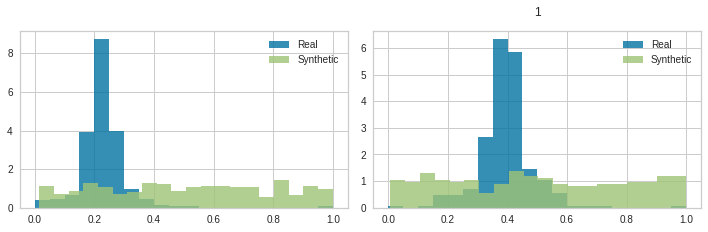

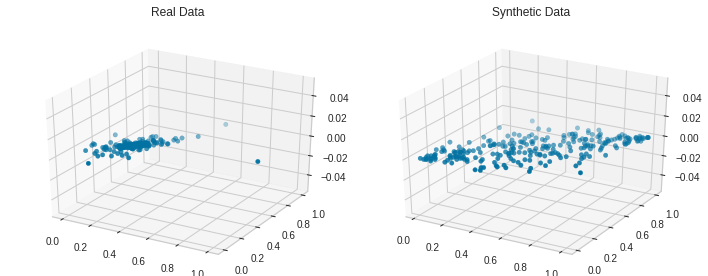

In [ ]:
sampled = non_gaussian_multivariate_copula.sample(len(rets_for_copula_modeling_scaled))
copulas.visualization.compare_1d(pd.DataFrame(rets_for_copula_modeling_scaled), pd.DataFrame(sampled))
copulas.visualization.compare_3d(pd.DataFrame(rets_for_copula_modeling_scaled), pd.DataFrame(sampled))
plt.tight_layout();

In [ ]:
correlation_nongaussian_copula = np.array(non_gaussian_multivariate_copula.compute_theta())

In [ ]:
print("The kendal's tau correlation for the non-gaussian copula", (correlation_nongaussian_copula-1)/(correlation_nongaussian_copula))

The kendal's tau correlation for the non-gaussian copula 0.5551485943775101


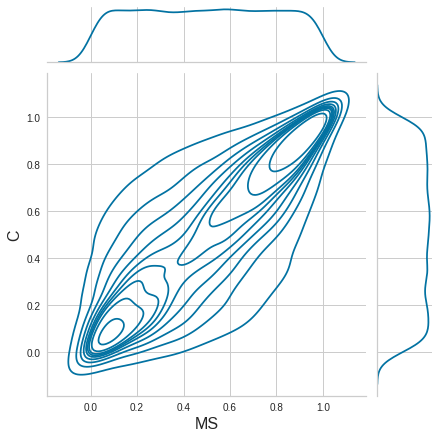

In [ ]:
viz_data = non_gaussian_multivariate_copula.sample(10_000)
h = sns.jointplot(x=viz_data[:, 0], y=viz_data[:, 1], kind='kde', stat_func=None);
h.set_axis_labels('MS', 'C', fontsize=16);

## 5.3  Comment on the comparison of fits


The pearson correlation value $\rho$ for the gaussian copula is essential the diagonal of the covariance matrix (given the assumption that the returns is a good approximation of the z-scoring). Since the gaussian distribution does not allow asymmetries, the two non singular values of the diagonal are the same. To convert the pearson correlation value to kendall's tau using: $\tau = (2/\pi)*arcsin(\rho)$

For the Gumbel copula, we can compute the theta of the distribution from built in library functions. Once theta is calculated, kendal's tau can be obtained using:
$τ = \frac{θ−1}{θ} $
Kendal's tau can now be used as the correlation value. 


Since the underlying data showed properties of a normal distribution and the kendall's tau calculated is closest to that of the non-gaussian copula, it is safe to assume that the Gumbel copula is the best fit for this data. If we had to choose among several copulae families, the method of estimating parameter such that they fit underlying data's dependence measure is the simplest method of selecting copulae. Quantitatively, this equates to a loss function minimizing the difference between the dependence metric of the copula and the dependence metric of the underlying data. This method is known as the IFM method and has been described in depth by Durrleman, Nikeghbali & Roncalli.

[Durrleman, Valdo & Nikeghbali, Ashkan & Roncalli, Thierry. (2000). Which Copula is the Right One?. SSRN Electronic Journal. 10.2139/ssrn.1032545. ]

# 6. Data Modeling



## 6.1 Using data pre-crisis, run any model from Machine Learning (LASSO, CART, PCA, NN, SVM, Bayes, or other ML techniques)

We will implement a simple, 2-layer LSTM model to predict returns for the various securities prior to the crisis

In [ ]:
def standard_scaler(X_train, X_test):
    train_samples, train_nx, train_ny = X_train.shape
    test_samples, test_nx, test_ny = X_test.shape
    
    X_train = X_train.reshape((train_samples, train_nx * train_ny))
    X_test = X_test.reshape((test_samples, test_nx * test_ny))
    
    preprocessor = StandardScaler().fit(X_train)
    X_train = preprocessor.transform(X_train)
    X_test = preprocessor.transform(X_test)
    
    X_train = X_train.reshape((train_samples, train_nx, train_ny))
    X_test = X_test.reshape((test_samples, test_nx, test_ny))
    
    return X_train, X_test

In [ ]:
def preprocess_data(stocks, seq_len):
    amount_of_features = len(stocks.columns)
    data = stocks.values
    
    sequence_length = seq_len + 1
    result = []
    for index in range(len(data) - sequence_length):
        result.append(data[index : index + sequence_length])
        
    result = np.array(result)
    row = round(0.9 * result.shape[0])
    train = result[: int(row), :]
    
    train, result = standard_scaler(train, result)
    
    X_train = train[:, : -1]
    y_train = train[:, -1][: ,-1]
    X_test = result[int(row) :, : -1]
    y_test = result[int(row) :, -1][ : ,-1]

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features))  

    return [X_train, y_train, X_test, y_test]

In [ ]:
def build_model(layers):
    model = Sequential()

    # By setting return_sequences to True we are able to stack another LSTM layer
    model.add(LSTM(units=64,
        return_sequences=True))
    model.add(Dropout(0.4))

    model.add(LSTM(
        layers[2],
        return_sequences=False))
    model.add(Dropout(0.3))

    model.add(Dense(
        layers[3]))
    model.add(Activation("linear"))

    start = time.time()
    model.compile(loss="mse", optimizer="adam", metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

In [ ]:
pre_crisis = returns.query('Date < "2008-9-1"')
post_crisis = returns.query('Date >= "2008-9-1"')

In [ ]:
window = 20
X_train, y_train, X_test, y_test = preprocess_data(pre_crisis, window)

In [ ]:
model = build_model([X_train.shape[2], window, 100, 1])

Compilation Time :  0.011076211929321289


In [ ]:
model.fit(
    X_train,
    y_train,
    batch_size=1,
    epochs=150,
    validation_split=0.1,
    verbose=1)

Epoch 1/150
84/84 [==============================] - 5s 21ms/step - loss: 1.2631 - accuracy: 0.0000e+00 - val_loss: 0.6176 - val_accuracy: 0.0000e+00
Epoch 2/150
84/84 [==============================] - 1s 10ms/step - loss: 0.7413 - accuracy: 0.0000e+00 - val_loss: 0.6084 - val_accuracy: 0.0000e+00
Epoch 3/150
84/84 [==============================] - 1s 10ms/step - loss: 1.5013 - accuracy: 0.0000e+00 - val_loss: 0.6106 - val_accuracy: 0.0000e+00
Epoch 4/150
84/84 [==============================] - 1s 10ms/step - loss: 1.5056 - accuracy: 0.0000e+00 - val_loss: 0.5952 - val_accuracy: 0.0000e+00
Epoch 5/150
84/84 [==============================] - 1s 10ms/step - loss: 0.6474 - accuracy: 0.0000e+00 - val_loss: 0.5965 - val_accuracy: 0.0000e+00
Epoch 6/150
84/84 [==============================] - 1s 11ms/step - loss: 2.3537 - accuracy: 0.0000e+00 - val_loss: 0.5913 - val_accuracy: 0.0000e+00
Epoch 7/150
84/84 [==============================] - 1s 10ms/step - loss: 2.3604 - accuracy: 0.0000e

In [ ]:
trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], np.sqrt(trainScore[0])))

testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], np.sqrt(testScore[0])))

Train Score: 0.09 MSE (0.29 RMSE)
Test Score: 0.75 MSE (0.86 RMSE)


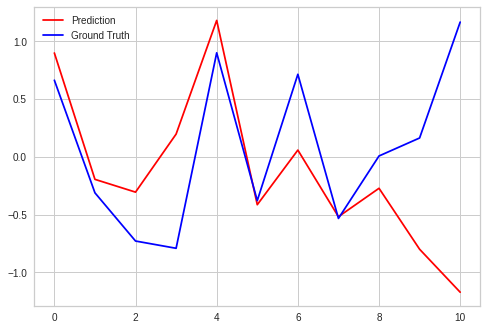

In [ ]:
diff = []
ratio = []
pred = model.predict(X_test)
for u in range(len(y_test)):
    pr = pred[u][0]
    ratio.append((y_test[u] / pr) - 1)
    diff.append(abs(y_test[u] - pr))

plt.plot(pred, color='red', label='Prediction')
plt.plot(y_test, color='blue', label='Ground Truth')
plt.legend(loc='upper left')
plt.title("Last 10 days forecasted for Wells Fargo (pre-crisis) using the other tickers as regressor variables")
plt.show()

## 6.2 Post Crisis 

In [ ]:
window = 20
X_train, y_train, X_test, y_test = preprocess_data(post_crisis, window)

In [ ]:
model = build_model([X_train.shape[2], window, 100, 1])

Compilation Time :  0.007977724075317383


In [ ]:
model.fit(
    X_train,
    y_train,
    batch_size=1,
    epochs=150,
    validation_split=0.1,
    verbose=1)

Epoch 1/150
83/83 [==============================] - 5s 21ms/step - loss: 1.1097 - accuracy: 0.0000e+00 - val_loss: 1.2366 - val_accuracy: 0.0000e+00
Epoch 2/150
83/83 [==============================] - 1s 11ms/step - loss: 0.9056 - accuracy: 0.0000e+00 - val_loss: 1.1862 - val_accuracy: 0.0000e+00
Epoch 3/150
83/83 [==============================] - 1s 10ms/step - loss: 1.1230 - accuracy: 0.0000e+00 - val_loss: 1.2061 - val_accuracy: 0.0000e+00
Epoch 4/150
83/83 [==============================] - 1s 11ms/step - loss: 1.1244 - accuracy: 0.0000e+00 - val_loss: 1.1648 - val_accuracy: 0.0000e+00
Epoch 5/150
83/83 [==============================] - 1s 11ms/step - loss: 1.0480 - accuracy: 0.0000e+00 - val_loss: 1.1876 - val_accuracy: 0.0000e+00
Epoch 6/150
83/83 [==============================] - 1s 11ms/step - loss: 0.8909 - accuracy: 0.0000e+00 - val_loss: 1.2615 - val_accuracy: 0.0000e+00
Epoch 7/150
83/83 [==============================] - 1s 10ms/step - loss: 0.9944 - accuracy: 0.0000e

In [ ]:
trainScore = model.evaluate(X_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore[0], np.sqrt(trainScore[0])))

testScore = model.evaluate(X_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore[0], np.sqrt(testScore[0])))

Train Score: 0.30 MSE (0.55 RMSE)
Test Score: 3.25 MSE (1.80 RMSE)


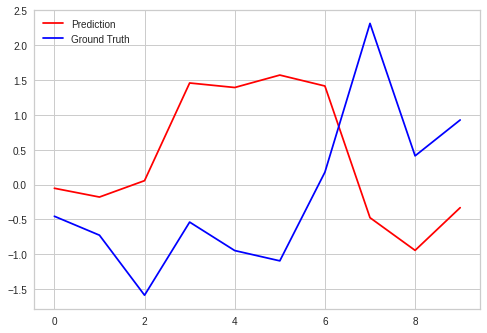

In [ ]:
diff = []
ratio = []
pred = model.predict(X_test)
for u in range(len(y_test)):
    pr = pred[u][0]
    ratio.append((y_test[u] / pr) - 1)
    diff.append(abs(y_test[u] - pr))

plt.plot(pred, color='red', label='Prediction')
plt.plot(y_test, color='blue', label='Ground Truth')
plt.title("Last 10 days forecasted for Wells Fargo (post-crisis) using the other tickers as regressor variables")
plt.legend(loc='upper left')
plt.show()